# **Data representation, reduction and analysis**
# **Youtube Comments Spam Classifier**

The dataset used in this project is a collection of YouTube comments made from users in music videos of artists: Psy, Katy Perry, LMFAO, Eminem, and Shakira.

In these datasets, there is a class column where (0) indicates that it is not a spam and (1) if it is a Spam.

We will use this to build models which classify the comment is either a spam or not.


In [1]:
!pip install emoji

     |████████████████████████████████| 51kB 2.8MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49717 sha256=52a3d34bb59c5b40ea611aa25d64caa1d326316f19083dc665fcfb2fc3c9f3f5
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from collections import Counter
from wordcloud import WordCloud
import nltk
import html
import re
import string
import emoji

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## **Importing dataset.**
First off we will be importing the datasets using the pandas library. the dataset from each csv file is merged into a variable called frames. ignore_index which is False in default is set to True so the resulting index will be written 0,1..n-1

In [4]:
df1 = pd.read_csv('Youtube01-Psy.csv')
df2 = pd.read_csv('Youtube02-KatyPerry.csv')
df3 = pd.read_csv('Youtube03-LMFAO.csv')
df4 = pd.read_csv('Youtube04-Eminem.csv')
df5 = pd.read_csv('Youtube05-Shakira.csv')

frames = [df1,df2,df3,df4,df5]
df = pd.concat(frames, ignore_index=True)
df.to_csv("not_clean.csv")

The shape of the concatenated dataframe **df** is:


In [5]:
print(df.shape)

(1956, 5)


Here we can see what the columns of the datasets comprise of :

In [6]:
print(df.columns)

Index(['COMMENT_ID', 'AUTHOR', 'DATE', 'CONTENT', 'CLASS'], dtype='object')


We can observe on the following table, the first 5 comments. Each row represents a comment and the columns show details about each comment. We are interested in the last 2 columns, **CONTENT** and **CLASS**.  The **CONTENT **column contains the contents of all the comments. The **CLASS **column specifies if the comment is classifiead as spam or legitimate(ham).

In [7]:
df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


## **Exploratory Data Analysis (EDA).**
Distribution by label: Spam count is slightly more than spam although not significant.

Text(0.5, 1.0, 'Frequency of Ham(0) & Spam(1)')

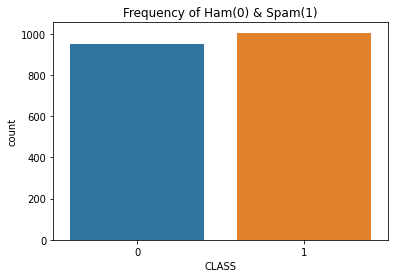

In [9]:
sb.countplot(x='CLASS',data=df).set_title("Frequency of Ham(0) & Spam(1)")

Now we can explore the average length of a spam or a ham. First we obtain the lenght of each comment and storing them in a new column called "comment_len".

In [10]:
df['comment_len'] = df['CONTENT'].apply(len)
df.head(5)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,comment_len
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,166
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1,38
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,48
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1,39


The describe method from the Pandas library gives us descriptive statistics that summarize the tendency, dispersion and the dataset distribution.

In [11]:
df.groupby('CLASS').describe()

comment_len                                                         
            count        mean         std   min   25%   50%    75%     max
CLASS                                                                     
0           951.0   49.644585   56.284782   2.0  18.0  34.0   62.0   753.0
1          1005.0  137.336318  158.977404  10.0  36.0  65.0  171.0  1200.0

Let's visualize distribution pattern of comment length by plotting a boxplot and normalized histgram. We can see that Spam messages are in general consists of more words compared to ham which makes sense because a comment unrelated to the video might been a comment which is trying to lure viewers into their site as compared to the normal comments in a youtube video.

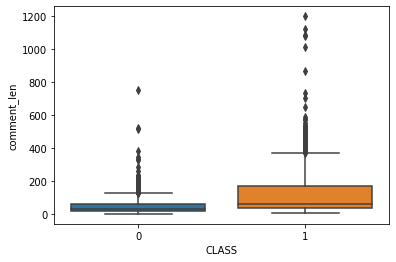

In [12]:
sb.boxplot(x='CLASS', y='comment_len', data=df)

In [13]:
spam_comments = df[df["CLASS"] == 1]["CONTENT"]
ham_comments = df[df["CLASS"] == 0]["CONTENT"]
all_comments = df["CONTENT"]

spam_words = ''
ham_words = ''
all_words = ''

"insert all available words in the column individually and count the most occuring word into an empty string"
for word in spam_comments:
    text = word.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '
        
for word in ham_comments:
    text = word.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

for word in all_comments:
    text = word.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        all_words = all_words + words + ' '

In [14]:
spamcloud = WordCloud(width=300, height=300).generate_from_text(spam_words)
hamcloud = WordCloud(width=300, height=300).generate_from_text(ham_words)
allcloud = WordCloud(width=300, height=300).generate_from_text(all_words)

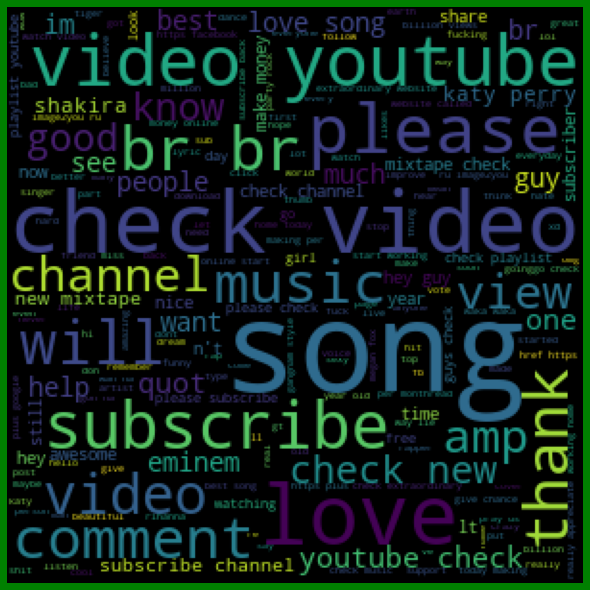

In [15]:
#All words in the dataset Word cloud
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(allcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

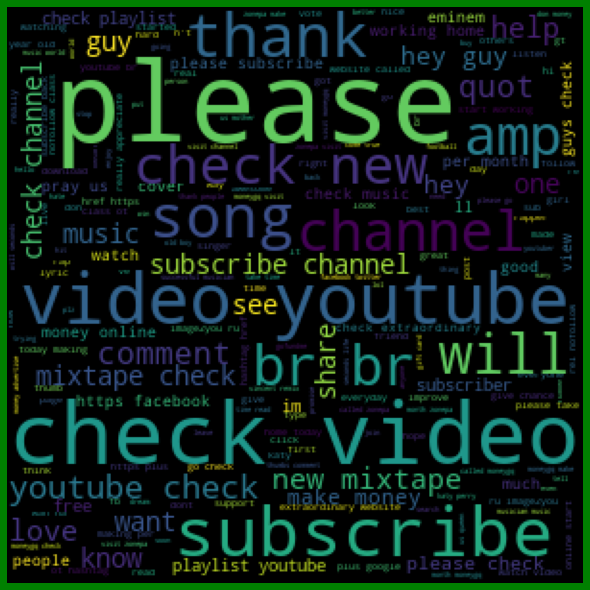

In [16]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(spamcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

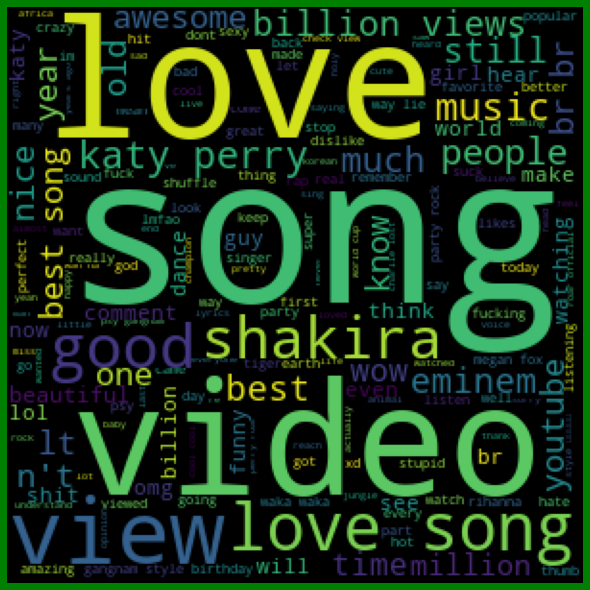

In [17]:
#Ham Word cloud
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(hamcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

We can see from the wordcloud that words in spam comments consist lots words that doesn' relate to the video which in this case are music videos. The words that exist consist of lots of words such as 'check', 'subscribe', 'please', 'help', which are comments to lure people to check or subscribe to their channel which is clearly spam words. 

Looking at the word cloud for all words, we can see that the word 'check', 'subscribe', 'please' is one of the most populated words in the dataset. These frequent words can be an explaination for the variability in end spam classification. 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


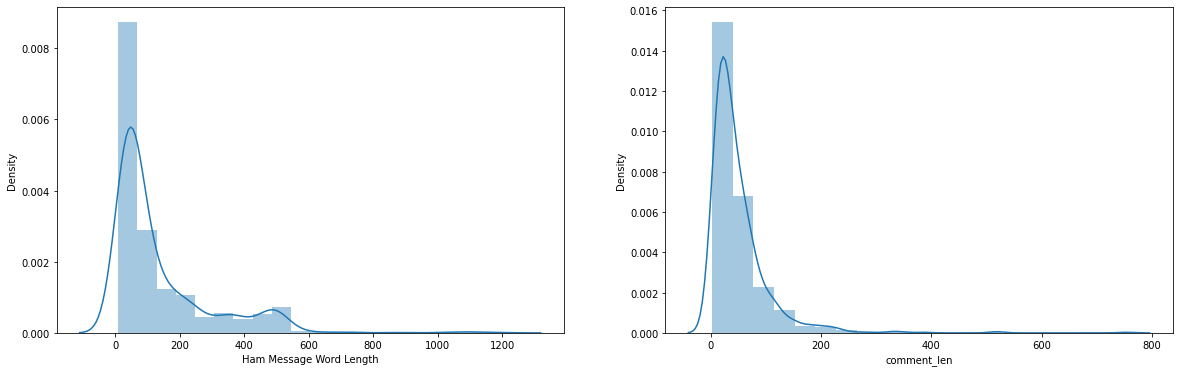

In [18]:
f, ax = plt.subplots(1, 2, figsize = (20, 6))

sb.distplot(df[df["CLASS"] == 1]["comment_len"], bins = 20, ax = ax[0])
ax[0].set_xlabel("Spam Messages Word Length")

sb.distplot(df[df["CLASS"] == 0]["comment_len"], bins = 20, ax = ax[1])
ax[0].set_xlabel("Ham Message Word Length")

plt.show()

In [19]:
df.comment_len.describe()

count    1956.000000
mean       94.700920
std       128.222062
min         2.000000
25%        29.000000
50%        48.000000
75%        97.000000
max      1200.000000
Name: comment_len, dtype: float64

In [20]:
# Let's see the longest message 1200
df[df['comment_len'] == 1200]['CONTENT'].iloc[0]

'&lt;script&gt;document.write(\'&lt;a target="_self" href=" http://rover.ebay.com/rover/1/710-53481-19255-0/1?icep_ff3=1&amp;pub=5575096797&amp;toolid=10001&amp;campid=5337555197&amp;customid=bogdan+grigore&amp;ipn=psmain&amp;icep_vectorid=229508&amp;kwid=902099&amp;mtid=824&amp;kw=lg"&gt;check  this out new arive on ebay&lt;/a&gt;&lt;img  style="text-decoration:none;border:0;padding:0;margin:0;" src=" http://rover.ebay.com/roverimp/1/710-53481-19255-0/1?ff3=1&amp;pub=5575096797&amp;toolid=10001&amp;campid=5337555197&amp;customid=bogdan+grigore&amp;mpt=\'+Math.floor(Math.random()*999999999)+\'"&gt;\');&lt;/script&gt;&lt;noscript&gt;&lt;a  target="_self" href=" http://rover.ebay.com/rover/1/710-53481-19255-0/1?icep_ff3=1&amp;pub=5575096797&amp;toolid=10001&amp;campid=5337555197&amp;customid=bogdan+grigore&amp;ipn=psmain&amp;icep_vectorid=229508&amp;kwid=902099&amp;mtid=824&amp;kw=lg"&gt;check  this out new arive on ebay&lt;/a&gt;&lt;img  style="text-decoration:none;border:0;padding:0;ma

## **Dataset Cleaning.**
On this subsection we are going to proceed with the cleaning of the dataset.

We only need data from COMMENT and CLASS column. So, we will drop the other columns that are not revelant to this project.



In [21]:
df = df.drop(['COMMENT_ID', 'AUTHOR', 'DATE', 'comment_len'], axis=1)

In [22]:
print(df.describe)

<bound method NDFrame.describe of                                                 CONTENT  CLASS
0     Huh, anyway check out this you[tube] channel: ...      1
1     Hey guys check out my new channel and our firs...      1
2                just for test I have to say murdev.com      1
3      me shaking my sexy ass on my channel enjoy ^_^ ﻿      1
4               watch?v=vtaRGgvGtWQ   Check this out .﻿      1
...                                                 ...    ...
1951  I love this song because we sing it at Camp al...      0
1952  I love this song for two reasons: 1.it is abou...      0
1953                                                wow      0
1954                            Shakira u are so wiredo      0
1955                         Shakira is the best dancer      0

[1956 rows x 2 columns]>


First we will lowercase all the comments, and then we will replace all the URLs with the keyword **htmllink**.

In [23]:
df["CONTENT"] = df["CONTENT"].str.lower() # Lowercase all the words in the df column "CONTENT"
df['CONTENT'] = df['CONTENT'].str.replace("(<a.+>)","htmllink") # Replace all the html tags <a... > with the keyword "htmllink"
df['CONTENT'] = df['CONTENT'].str.replace("(<.+>)","") # Remove all other html tags.
df['CONTENT'] = df['CONTENT'].str.replace(r'(https?://\S+|http?://\S+ )',"htmllink") # Replace all the strings starting with "http" or "https" with the keyword "htmllink"
df["CONTENT"] = df["CONTENT"].str.replace(r"\S*.com\S*|\S*watch\?\S*","htmllink") # Replace all the strings containing ".com"  or "watch\"  with the keyword "htmllink"

We will create 3 funtions:

*   **clean_nonalpha:** removes all the nonalphabethic characters from the comments.
*   **translate_emojis:** since a lot of comments contain emojis, we will translate them to a keyword representation using the library "emoji".
*   **clean_only_numbers:** we will remove the words containing just numbers.




In [24]:
def clean_nonalpha(input_text):
  pattern = re.compile('([^\s\w]|)+')
  return pattern.sub("",input_text)

In [25]:
def translate_emojis(input_text):
  return emoji.demojize(input_text, delimiters=(" ", " "))

In [26]:
def clean_only_numbers(input_text):
  return ' '.join(word for word in input_text.split() if not word.isdigit())

In [27]:
df["CONTENT"]=df["CONTENT"].apply(translate_emojis)
df["CONTENT"]=df["CONTENT"].apply(clean_nonalpha)
df["CONTENT"]=df["CONTENT"].apply(clean_only_numbers)

Now that we have cleaned the dataset, let's observe the words cloud.

In [28]:
clean_spam_comments = df[df["CLASS"] == 1]["CONTENT"]
clean_ham_comments = df[df["CLASS"] == 0]["CONTENT"]

spam_words = ''
ham_words = ''

for word in spam_comments:
    text = word.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '
        
for word in ham_comments:
    text = word.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '


In [29]:
clean_spamcloud = WordCloud(width=300, height=300).generate_from_text(spam_words)
clean_hamcloud = WordCloud(width=300, height=300).generate_from_text(ham_words)

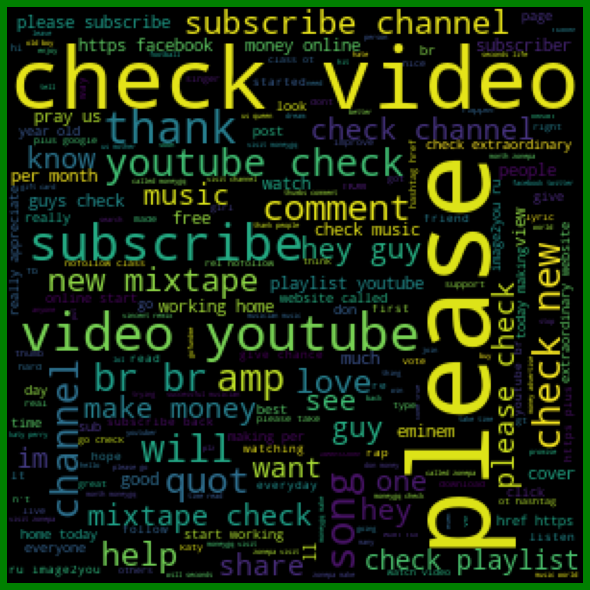

In [30]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(clean_spamcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

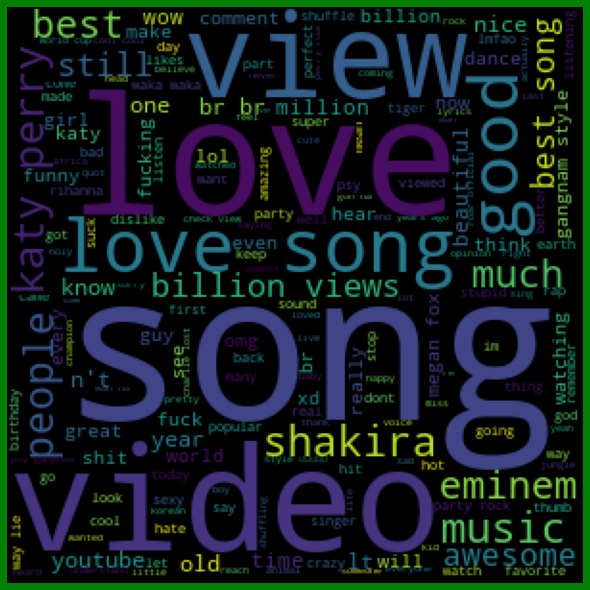

In [31]:
#Ham Word cloud
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(clean_hamcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In order to apply a classification ML algorithm, we first need to get a numerical representation of all the comments. We are going to use two **Word Embeddings models** using Natural Language Processing techniques to map the comments into vectors of real numbers.

According to the paper "TubeSpam: Comment Spam Filtering on YouTube", they achieved better results by not filtering stopwords and lemmatizing. This first approach (Bag of Words) we are not going to perform further filtering ( remove stopwords and lemmatize) ...

## **Model 1: Bag of Words.**

Bag of Words (BoW) is an algorithm that counts how many times a word appears in a document. It’s a tally where the word counts in every document or in our case the comments allow us to compare documents and gauge their similarities for spam or ham classification.

BoW works by listing words and have them paired with their word counts per document. In the table where the words and documents that effectively become vectors are stored, each **row is a word**, each **column is a document**, and each cell is a word count given by for example in "[1 0 1 0]". Each of the documents in the corpus is represented by columns of equal length which are the wordcount vectors, an output stripped of context.

In the approach below, we will create a vocab set, that stores all the words used on all the dataset, and after that each comment will be represented by a vector of the size of the vocabulary: so for example the sentence "hello word" is going to be represented as [ 0 0 1 0 1] ( considering that our vocabulary contains just 5 words { word1 word2 hello word3 world} which we will then fit it into a classifier.

In [32]:
vocab = []
for sentence in df["CONTENT"]:
  for word in sentence.split():
    vocab.append(word)

The vocabulary contains all the distinct words in the dataset.

In [33]:
# Eliminate duplicate words in the vocabulary
vocabulary = set(vocab)
print(len(vocabulary))

3849


For every word in the vocabulary we are going to create a new column in the dataset.

In [34]:
for word in vocabulary:
  df[word] = 0

For every ocurrence of a word in a sentence (comment) we are going to increment the counter of each word by one.

In [35]:
for index, sentence in enumerate(df["CONTENT"]):
  for word in sentence.split():
    df[word].iloc[index] += 1  


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Now we can create two sub dataframes containing the words embeddings for spam and ham comments.

In [36]:
df_spam =df[df["CLASS"] == 1]
df_spam.loc['Total']= df_spam.sum(numeric_only=True, axis=0)
df_spam.tail()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,CONTENT,CLASS,statement,train,moved,worked,wanna,exactly,subcribe,valuable,dude,woods,setting,effects,finally,she,bs,lets,channelthanks,crashed,upload,conquerors,chose,hurts,goo,doh,remeber,abuses,it,walmart,id,wish,donating,pleaaaase,up,trelod,chick,sophisticated,perform,nikki,...,price515,sucscribe,releasing,smiley,totally,currently,songhas,enimen,somehow,range,sleep,sparkles,reading,t,edlikeampshare,pleasealso,hero,qiameth,wafence,anaconda,challenge,fans,kingston,devils,repair,mê,copy,drone,wages,htmllinkand,bass,sexual,course,increidebl,is,herd,twitter,tv,linked,bigger
1944,hey music fans i really appreciate all of you ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1945,check out my new mixtape check out my new mixt...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1946,check out my new mixtape check out my new mixt...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1947,check out my new mixtape check out my new mixt...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Total,NaN,1005.0,1.0,1.0,1.0,1.0,13.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,13.0,0.0,3.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,222.0,1.0,1.0,4.0,1.0,1.0,104.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,5.0,0.0,0.0,0.0,6.0,1.0,0.0,18.0,13.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,15.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,0.0,1.0,0.0,109.0,1.0,11.0,1.0,1.0,1.0


In [37]:
print(df_spam.shape)

(1006, 3851)


In [38]:
df_not_spam =df[df["CLASS"] == 0]
df_not_spam.loc['Total']= df_not_spam.sum(numeric_only=True, axis=0)
df_not_spam.tail()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,CONTENT,CLASS,statement,train,moved,worked,wanna,exactly,subcribe,valuable,dude,woods,setting,effects,finally,she,bs,lets,channelthanks,crashed,upload,conquerors,chose,hurts,goo,doh,remeber,abuses,it,walmart,id,wish,donating,pleaaaase,up,trelod,chick,sophisticated,perform,nikki,...,price515,sucscribe,releasing,smiley,totally,currently,songhas,enimen,somehow,range,sleep,sparkles,reading,t,edlikeampshare,pleasealso,hero,qiameth,wafence,anaconda,challenge,fans,kingston,devils,repair,mê,copy,drone,wages,htmllinkand,bass,sexual,course,increidebl,is,herd,twitter,tv,linked,bigger
1952,i love this song for two reasons 1it is about ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1953,wow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1954,shakira u are so wiredo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1955,shakira is the best dancer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Total,NaN,0.0,0.0,1.0,0.0,0.0,6.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,54.0,1.0,6.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,1.0,112.0,0.0,1.0,2.0,0.0,0.0,18.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,214.0,0.0,0.0,3.0,0.0,1.0


In [61]:
print(df_not_spam.shape)

(952, 3851)


Drop the first two columns of each dictionary.

In [39]:
df_spam.drop("CONTENT",1,inplace=True)
df_spam.drop("CLASS",1,inplace=True)
df_not_spam.drop("CONTENT",1,inplace=True)
df_not_spam.drop("CLASS",1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We create a dictionary from each dataframe created for spam and ham comments.

In [40]:
dict_spam = {word: count for word, count in zip(df_spam.columns,df_spam.loc['Total'])}
dict_not_spam = {word: count for word, count in zip(df_not_spam.columns,df_not_spam.loc['Total'])}

We can now sort the dictionaries and obtain the most frequent words in the spam and ham dictionaries.

In [41]:
sorted_spam = sorted(dict_spam.items(),key=lambda x: x[1], reverse=True)
sorted_not_spam = sorted(dict_not_spam.items(),key=lambda x: x[1], reverse=True)
print(sorted_spam[:10])
print(sorted_not_spam[:10])

[('out', 569.0), ('check', 545.0), ('htmllink', 514.0), ('my', 512.0), ('and', 485.0), ('to', 480.0), ('you', 463.0), ('i', 457.0), ('the', 413.0), ('a', 389.0)]
[('this', 293.0), ('i', 284.0), ('the', 278.0), ('song', 217.0), ('is', 214.0), ('love', 144.0), ('to', 133.0), ('and', 132.0), ('a', 114.0), ('it', 112.0)]


### **Classification.**
For classification there are some famous classification algorithms and we are going to use the below classification algorithms with this data set and see their prediction results The Algorithms used below in this notebooks are :

- K-Nearest Neighbour
- Support Vector Machine 
- Gaussian Naive Bayes

We have chosen these classifiers because they tend to have a decent performance for this type of dataset and typically do not need much setup.

In [136]:
X = df.iloc[:,2:]
y = df.iloc[:,1]
pd.crosstab(index=y,columns="Count")

col_0,Count
CLASS,
0,951
1,1005



We are going to use the **Hold Out Validation** method for our classifiers. it basically consist on dividing the dataset into 2 parts, a training dataset and a testing dataset. We are going to apply the standard segmentation commmonly used that is 75% of the dataset correspond to the training dataset and the rest for the testing dataset.

In [137]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

#### **Support Vector Machines: Linear Kernel.**


In [138]:
from sklearn.svm import SVC #support vector classifier
clf = SVC(kernel='linear', random_state=0, gamma=0.001).fit(X_train, y_train)
print(clf)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


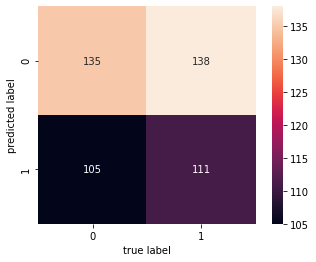

In [139]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_pred_svm = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [140]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.49      0.56      0.53       240
           1       0.51      0.45      0.48       249

    accuracy                           0.50       489
   macro avg       0.50      0.50      0.50       489
weighted avg       0.50      0.50      0.50       489



#### **Naive Bayes.**

The Naive Bayes algorithm is a classification algorithm which is less intense in terms of calculating, and hence is favorable for quickly developing mining designs to find out the association between input and predictable columns. A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. 

For example, a banana may be yellow, curvy in shape and about 15cm long. Even if these features depend on each other or upon the existence of the other features, all of these properties independently contribute to the probability that this fruit is an apple and that is why it is known as ‘Naive’.

We will use sklearns sklearn.naive_bayes method to make predictions on our dataset.

Specifically, we will be using the multinomial Naive Bayes. This particular classifier is suitable for classification with discrete features (such as in our case, word counts for text classification). It takes in integer word counts as its input.

Multinomial Naive Bayes is used for discrete counts. For example, let’s say,  we have a text classification problem. Here we can consider Bernoulli trials which is one step further and instead of “word occurring in the document”, we have “count how often word occurs in the document”, we can think of it as “number of times outcome number x_i is observed over the n trials” (Analytics Vidhya, Naive Bayes).

the alpha parameter in MultinomialNB is set to 0.75 because the accuracy score is the best at this number as compared to the default value 1.0

In [141]:
# import and initialize a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=0.75)

In [142]:
#Train model
nb.fit(X_train, y_train)

MultinomialNB(alpha=0.75, class_prior=None, fit_prior=True)

In [143]:
#Predict the outcome of either spam or ham
y_pred_NB = nb.predict(X_test)

In [144]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_NB)

0.9263803680981595

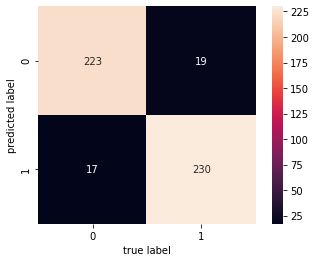

In [145]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_NB) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [146]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_NB, digits=4))

              precision    recall  f1-score   support

           0     0.9215    0.9292    0.9253       240
           1     0.9312    0.9237    0.9274       249

    accuracy                         0.9264       489
   macro avg     0.9263    0.9264    0.9264       489
weighted avg     0.9264    0.9264    0.9264       489



From the confusion matrix we see:

- There are 241 actual ham (class 0)
- There 248 actual spam (class 1)

Our Naive Bayes classifier more or less classified most of the actual ham messages. There are some ham classed as spam (false positives)- which is not that ideal for a spam classifier considering some of the ham messages will be identified as spam. The number of false positives altho quite low they (where spam is positive class) are not still ideal because some ham messages will be classified as spam.

When it comes to the actual spam messages, the classifier has correctly identified 220 spam messages, but it has also classified 28 spam as ham (false negatives), so it is most recipients are likely to be getting 1 unfiltered spam messages out of 10 filtered.

However for the classification report, the recall for ham is okay-ish but we are pulling in some spam messages as well (precision = 0.90)

The classifier's ability to find all the spam messages is better at recall = 0.90, altho some ham messages will still be pulled in with the precision = 0.89

#### **K-Nearest Neighbors.**
K nearest neighbors is a simple algorithm that stores all available cases and classifies new cases based on a similarity measure, in this case we will use the euclidean distance as the similarity metric.

The KNN algorithm has 3 stages:

Step 1: Calculate Euclidean Distance.

Step 2: Get Nearest Neighbors.

Step 3: Make Predictions.

Evaluating the Algorithm

In [214]:
class KNN:
  def __init__(self,X_train,X_test,y_train,y_test,k):
    
    """
    @param self
    @param X_train: training points array.
    @param X_test: testing points array.
    @param y_train: training labels.
    @param y_test: testing labels.
    @param k: k nearest neighbors.
    """
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.k = k
    self.targets = y_test

  def euclidean(self,A, B):

    """
    Calculates the euclidean distance matrix between 2 input matrices. Performs
    step 1.
    @param A: input matrix A.
    @param B: input matrix B.
    @return: euclidean distance matrix.
    """
    n, d = A.shape
    m, d1 = B.shape
    assert d == d1, 'Incompatible shape'
    A_squared = np.sum(np.square(A), axis=1, keepdims=True)
    B_squared = np.sum(np.square(B), axis=1, keepdims=True)
    AB = np.matmul(A, B.T)
    distances = np.sqrt(A_squared - 2 * AB + B_squared.T)
    return distances
  def evaluate(self):
    """
    Evaluates the accuracy of the predictions
    @return: accuracy
    """
    acc = np.mean(self.predictions == self.targets)
    return acc
  def run(self):
    """
    Get the nearest neighbors and make predictions. Performs steps 2 and 3.
    @returns: predictions
    """
    distances = self.euclidean(self.X_test, self.X_train)
    n_test = self.X_test.shape[0]
    n_classes = len(np.unique(self.y_train))
    self.predictions = np.zeros(n_test, dtype=np.int8)
    nn_indices = np.argsort(distances,axis=1)[:,:self.k]
    votes = np.zeros((n_test, n_classes))
    for j in range(self.k):
        votes[np.arange(n_test) , self.y_train[nn_indices[:,j]]] += 1
    self.predictions = np.argmax(votes,axis=1)
    return self.predictions


In [148]:
k = 3
knn = KNN(X_train.to_numpy(),X_test.to_numpy(),y_train.to_numpy(),y_test.to_numpy(),k)
y_pred_knn = knn.run()
acc = knn.evaluate()


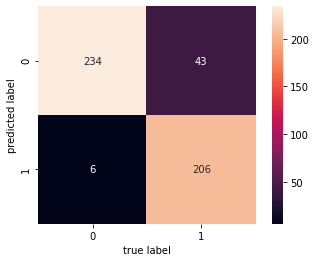

In [149]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_knn) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [150]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.84      0.97      0.91       240
           1       0.97      0.83      0.89       249

    accuracy                           0.90       489
   macro avg       0.91      0.90      0.90       489
weighted avg       0.91      0.90      0.90       489



We can calculate the accuracy for different k values, and see which k value is suitable.

In [151]:
acc_list = []
for i in range(1, 5):
    knn_i = KNN(X_train.to_numpy(),X_test.to_numpy(),y_train.to_numpy(),y_test.to_numpy(),i)
    pred_i = knn_i.run()
    #pred_i = knn.predict(X_test)
    acc_list.append(knn_i.evaluate())

In [152]:
print(acc_list)

[0.8813905930470347, 0.8670756646216768, 0.8997955010224948, 0.8875255623721882]


Text(0, 0.5, 'Accuracy')

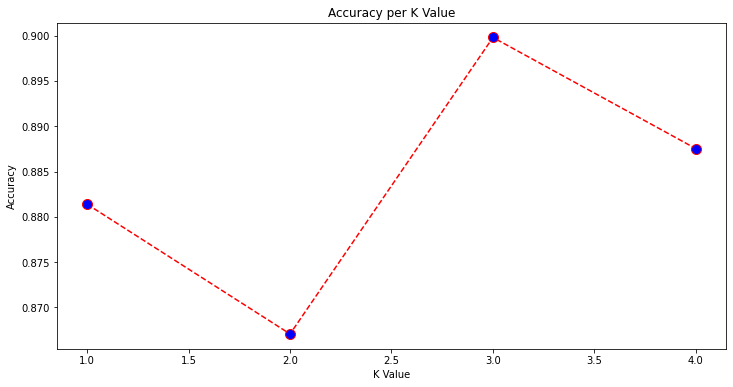

In [154]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 5), acc_list, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Accuracy per K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')

The accuracy almost remain the same for all the k values in the range of 1 to 5, but the higher accuracy was achieved why k=3.

### **Accuracy comparison.**

In [155]:
from sklearn.metrics import accuracy_score
print('Accuracy score for linear kernel: {}'.format(accuracy_score(y_test, y_pred)))
print('Accuracy score for multinomial naive bayes: {}'.format(accuracy_score(y_test, y_pred_NB)))
print('Accuracy score for KNN (k=3): {}'.format(accuracy_score(y_test, y_pred_knn)))

Accuracy score for linear kernel: 0.5030674846625767
Accuracy score for multinomial naive bayes: 0.9263803680981595
Accuracy score for KNN (k=3): 0.8997955010224948


We can see the Naive Bayes have the best score over other classification algorithms. Its ability to handle an extremely large number of features which is in our case, each word is treated as a feature and there are thousands of different words. Also, it performs well even with the presence of irrelevant features and is relatively unaffected by them as we can see by removing emojis from the comments. Also tuning the parameters for Naive Bayes' are not really necessary except when distribution of data is well known.

## **Model 2: Word2Vec.**

In the previous section we have seen how the result for the bag of words model, now we will use another embedding approach which is word2vec and then train the neural model with the dictionary of words of the dataset, where this will capture semantic relationships between words, and also reduce the number of features. 

Word2vec produces one vector per word which is great for going deeper into the documents we have and helps in identifying content and subsets of content. Its vectors represent each word’s context.

In [156]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.2MB 65.3MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [157]:
import spacy
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
import sys
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [158]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


For the Word2Vec implementation, we are going to create a class that contains three methods:
  

*   **clean_sentence**: Performs further cleaning of a comment in the dataset, specifically lemmatization and removing of stop words.
*   **clean_document**: Calls the clean_sentence method for all the comments, and drop duplicate comments (if there exists).
*   **run**: Executes the training process of the word2vec word embedding model.



In [217]:
class W2V_embedding:
  def __init__(self, document, lemma, stopwords, min_count, window, nlp):

    """
    @param self
    @param document: document that contains the sentences to be transformed into word2vec vectors.
    @param lemma: true if the sentences will be lemmatized, false otherwise.
    @param stopwords: true if the stopwords will be removed, false otherwise.
    @param min_count: minimun number of ocurrences of a word in order to be added to the model during the training process.
    @param window: context window for words during the training process.
    @param nlp: spacy loaded model.
    @return:
    """
    self.document = document
    self.nlp = nlp
    self.lemma = lemma
    self.stopwords = stopwords
    self.min_count = min_count
    self.window = window
  def clean_sentence(self, sentence):
    # Lemmatizes and removes stopwords
    if self.lemma and self.stopwords:
      txt = [token.lemma_ for token in sentence if not token.is_stop]
    elif self.lemma:
      txt = [token.lemma_ for token in sentence ]
    elif self.stopwords:
      txt = [token for token in sentence if not token.is_stop]
    return ' '.join(txt)
  def clean_document(self):
    #Clean and drop duplicates from the comments in the dataset.
    txt = [self.clean_sentence(sentence) for sentence in self.nlp.pipe(self.document, batch_size=500, n_threads=-1)]
    df_clean = pd.DataFrame({'clean': txt})
    df_clean = df_clean.dropna().drop_duplicates()
    sentences = [row.split() for row in df_clean['clean']]
    return sentences
  def run(self):
    self.sentences = self.clean_document()
    cores = multiprocessing.cpu_count() 
    w2v_model = Word2Vec(min_count=self.min_count,
                     window=self.window,
                     size=300,
                     workers=cores-1)
    w2v_model.build_vocab(self.sentences, progress_per=100)
    w2v_model.train(self.sentences, total_examples=w2v_model.corpus_count, epochs=50, report_delay=1)
    w2v_model.init_sims(replace=True)
    return w2v_model


For the training process, it is important to set up the min_count value to 1, since we have a small vocabulary and we would like to obtain a representation for every word in the dataset.

In [218]:
lemmatizer = True
remove_stopwords= True
nlp = spacy.load('en', disable=['ner','parser']) # We will disable the in-build Named Entity Recognizer and the Synthatic Dependency Parser.
init_w2v = W2V_embedding(min_count=1, window=5, lemma=lemmatizer, stopwords=remove_stopwords, document=df["CONTENT"], nlp=nlp)
w2v_model = init_w2v.run()

In [219]:
w2v_model.wv.most_similar(positive=["subscribe"])

[('thank', 0.9759703874588013),
 ('want', 0.9587589502334595),
 ('upload', 0.9486874341964722),
 ('decent', 0.9464796185493469),
 ('trailer', 0.9442321062088013),
 ('thumb', 0.9431902766227722),
 ('you39re', 0.9401564002037048),
 ('lot', 0.937326192855835),
 ('czfcxsn0jnq', 0.9336727857589722),
 ('hater', 0.9312293529510498)]

In [220]:
comments_array = np.zeros(shape=(len(df["CONTENT"]),300))
for index, sentence in enumerate(df["CONTENT"]):
  tokens = nlp(sentence)
  if lemmatizer and remove_stopwords:
    clean_sentence = [token.lemma_ for token in tokens if not token.is_stop]
  elif lemmatizer:
    clean_sentence = [token.lemma_ for token in tokens]
  elif remove_stopwords:
    clean_sentence = [token for token in tokens if not token.is_stop]
  sentence_vector = []
  for word in clean_sentence: # In the case a word is not found in the vocabulary, we will append a vector of zeros instead
    try: 
      sentence_vector.append(w2v_model[word] ) 
    except:
      sentence_vector.append(np.zeros(300))
      print(word, 'not found')
  comments_array[index] = np.mean(sentence_vector,axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [221]:
print(" Array of comments shape: ",comments_array.shape)
print(" Vocabulary size: ",len(w2v_model.wv.vocab))

 Array of comments shape:  (1956, 300)
 Vocabulary size:  3240


After the cleaning process, some comments are wiped out entirely. This is because the comments contain only stop words, which we decided to remove. In orther to avoid NaN values, we translate the NaN rows to an array of zeroes.

In [222]:
X = comments_array
isnan = np.argwhere(np.isnan(X))
nan_comments = sorted(set(isnan[:,0])) #index of comments that are NaN values

In [223]:
X[nan_comments,:] = np.zeros(300) # translating NaN comments to an array of zeroes
y = df.iloc[:,1]

### **Classification.**

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

#### **Support Vector Machines: Linear Kernel.**

In [226]:
clf = SVC(kernel='linear', random_state=0, gamma=0.001).fit(X_train, y_train)
print(clf)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


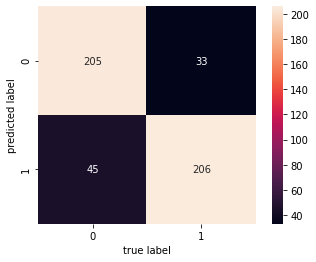

In [227]:
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [228]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       250
           1       0.82      0.86      0.84       239

    accuracy                           0.84       489
   macro avg       0.84      0.84      0.84       489
weighted avg       0.84      0.84      0.84       489



#### **Naive Bayes.** 

In [229]:
# import and initialize a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb2 = MultinomialNB(alpha=0.75)

#checking the range of the numpy array 
r = np.ptp(X_train,axis=1)
print(X_train)
print(r)
print("range of numpy array :", max(r), min(r))

[[-0.04253864  0.04854018 -0.0157744  ... -0.03055524 -0.02138907
  -0.00246237]
 [-0.01566469  0.07018167 -0.04554516 ... -0.00227061 -0.03280846
   0.04203266]
 [-0.00501604  0.08001684 -0.1130916  ...  0.02935002 -0.06136578
  -0.02624363]
 ...
 [ 0.01429808  0.04056725 -0.11289315 ... -0.00077366 -0.01549895
  -0.0048531 ]
 [-0.02382413  0.08753607 -0.0455605  ...  0.00238503 -0.06051697
   0.02403493]
 [-0.00204811  0.04671903 -0.12697977 ... -0.01918132 -0.01905886
   0.00675927]]
[0.32700358 0.3131438  0.29186371 ... 0.31638472 0.31011093 0.29988305]
range of numpy array : 0.38441917300224304 0.0


In [230]:
from sklearn.preprocessing import MinMaxScaler
#Normalizing the values in the array because naive bayes doesn't work with negative values
scaler = MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)

In [231]:
#Train model
nb2.fit(X_train_minmax, y_train)

MultinomialNB(alpha=0.75, class_prior=None, fit_prior=True)

In [232]:
#Predict the outcome of either spam or ham
y_pred_NB2 = nb2.predict(X_test)

In [233]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_NB2)

0.8057259713701431

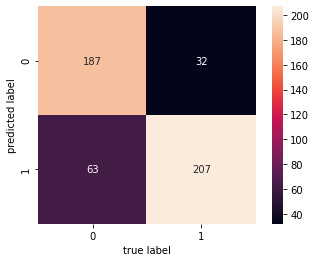

In [234]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_NB2) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [235]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_NB2, digits=4))

              precision    recall  f1-score   support

           0     0.8539    0.7480    0.7974       250
           1     0.7667    0.8661    0.8134       239

    accuracy                         0.8057       489
   macro avg     0.8103    0.8071    0.8054       489
weighted avg     0.8113    0.8057    0.8052       489



#### **K-Nearest Neighbors.**

 


KNN algorithm is one of the simplest of all the supervised machine learning algorithms. KNN algorithm simply calculates the distance of a new data point to all other training data points. the distance between data points can be any type. For ex. Euclidean or Manhattan etc. It then selects the K-nearest data points where K can be any integer. The algorithm then assigns the data points to the class to which the majority of the k data points belongs.

KNN algorithm is easy to implement in its basic form but it performs complex classification tasks. It is a lazy learning algorithm because it does not have a specialized training phase, rather it just uses all the data for training when it performs the tasks of classifying a new data point. KNN algorithm does not assume anything about the underlying data so it is a non-parametric learning algorithm. 

#### Implementing KNN Algorithm

Training and Predictions

 

At first step, value of k is initialized to 5. There is no ideal value for k and it is selected after evaluation, but 5 seems to be the most commonaly used value to start out for KNN algorithm. After that the prediction on our test data is made. 

In [247]:
k = 5
knn_w2v = KNN(X_train,X_test,y_train.to_numpy(),y_test.to_numpy(),k)
y_pred_knn_w2v = knn_w2v.run()
acc = knn.evaluate()

In [248]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_knn_w2v))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       250
           1       0.86      0.90      0.88       239

    accuracy                           0.88       489
   macro avg       0.88      0.88      0.88       489
weighted avg       0.88      0.88      0.88       489



#### Evaluating the Algorithm

For evaluating an algorithm, confusion matrix, precision, recall and f1 score are the most commonly used metrics. The confusion_matrix and classification_report methods of the sklearn.metrics can be used to calculate these metrics. The scripts are implemented as follows:

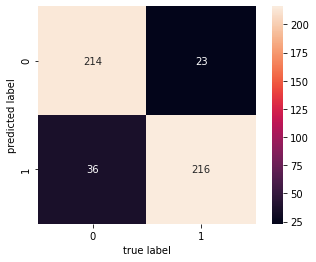

In [251]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_knn_w2v) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

#### Comparing Error Rate with the K Value

  
 

As mentioned earlier there is no way to know beforehand which value of k yields the best results. Before we just randomly choose the 5 as the k value. One way to find the best value of k is to plot the graph of k value and its corresponding error rate for the dataset. Below is the plot for the mean error for the predicted values of test set for all values of k in between 1 and 10.

In [252]:
acc_list = []
for i in range(1, 10):
    knn_i = KNN(X_train,X_test,y_train.to_numpy(),y_test.to_numpy(),i)
    pred_i = knn_i.run()
    #pred_i = knn.predict(X_test)
    acc_list.append(knn_i.evaluate())

Text(0, 0.5, 'Accuracy')

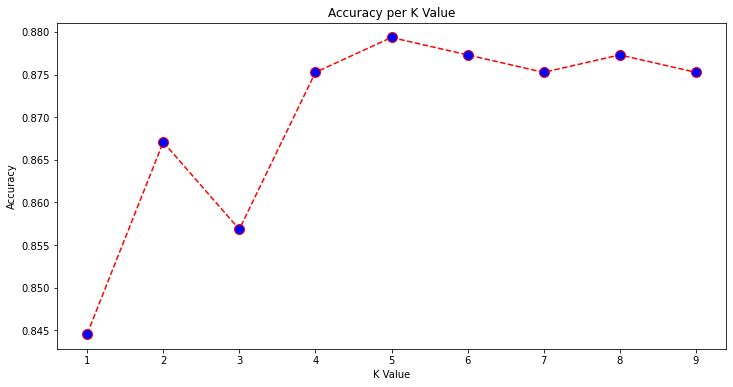

In [255]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 10), acc_list, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Accuracy per K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')

 

From the graph we can say that the algorithm reaches the highest accuracy with k = 5.

### **Accuracy comparison.**

In [254]:
from sklearn.metrics import accuracy_score
print('Accuracy score for linear kernel: {}'.format(accuracy_score(y_test, y_pred)))
print('Accuracy score for multinomial naive bayes: {}'.format(accuracy_score(y_test, y_pred_NB2)))
print('Accuracy score for KNN: {}'.format(accuracy_score(y_test, y_pred_knn_w2v)))

Accuracy score for linear kernel: 0.8404907975460123
Accuracy score for multinomial naive bayes: 0.8057259713701431
Accuracy score for KNN: 0.8793456032719836


## **Conclusion.**
The proposed approach is used to detect the spam in YouTube datasets using the word2vec and bag of words approach and the classifiers are generated by using SVM, Naıve Bayes, K-Nearest Neighbour and linear regression technique.

For the selected attributes we find out various patterns that will help in predicting the spam.

After testing various test scenarios we conclude that the proposed approach results in this classification process ??